# Kaggle cifar10 图像目标检测实战

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


## 数据读取

In [3]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

train_labels_file = './data/cifar10/trainLabels.csv'
test_csv_file = './data/cifar10/sampleSubmission.csv'
train_folder = './data/cifar10/train'
test_folder = './data/cifar10/test'

In [4]:
# 解析csv，构成(filename(path), label)形式
def parse_csv_file(filepath, folder):
    """Parses csv files into (filename(path), label) format"""
    results = []
    with open(filepath, 'r') as f:
        lines = f.readlines()[1:]
    for line in lines:
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder, image_id + '.png')
        results.append((image_full_path, label_str))
    return results

train_labels_info = parse_csv_file(train_labels_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)

import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[('./data/cifar10/train\\1.png', 'frog'),
 ('./data/cifar10/train\\2.png', 'truck'),
 ('./data/cifar10/train\\3.png', 'truck'),
 ('./data/cifar10/train\\4.png', 'deer'),
 ('./data/cifar10/train\\5.png', 'automobile')]
[('./data/cifar10/test\\1.png', 'cat'),
 ('./data/cifar10/test\\2.png', 'cat'),
 ('./data/cifar10/test\\3.png', 'cat'),
 ('./data/cifar10/test\\4.png', 'cat'),
 ('./data/cifar10/test\\5.png', 'cat')]
50000 300000


In [5]:
# 把训练集和测试集转换成DataFrame
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                     filepath       class
0  ./data/cifar10/train\1.png        frog
1  ./data/cifar10/train\2.png       truck
2  ./data/cifar10/train\3.png       truck
3  ./data/cifar10/train\4.png        deer
4  ./data/cifar10/train\5.png  automobile
                         filepath       class
0  ./data/cifar10/train\45001.png       horse
1  ./data/cifar10/train\45002.png  automobile
2  ./data/cifar10/train\45003.png        deer
3  ./data/cifar10/train\45004.png  automobile
4  ./data/cifar10/train\45005.png    airplane
                    filepath class
0  ./data/cifar10/test\1.png   cat
1  ./data/cifar10/test\2.png   cat
2  ./data/cifar10/test\3.png   cat
3  ./data/cifar10/test\4.png   cat
4  ./data/cifar10/test\5.png   cat


### 数据增强

In [6]:
# 将图片转化成同一尺寸
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

# 读取图片并增强
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale= 1./255, # 缩放到0-1之间
    rotation_range= 40, # 旋转范围
    width_shift_range= 0.2, # 水平位移
    height_shift_range= 0.2, # 竖直平移
    shear_range= 0.2, # 剪切范围
    zoom_range= 0.2, # 缩放范围
    horizontal_flip= True, # 随机水平翻转
    fill_mode= 'nearest', # 对空白位置的填充规则
)
# 按照DataFrame进行分类，进行数据增强
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    class_mode = 'sparse'
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale= 1./255, # 缩放到0-1之间
)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = 'sparse'
)

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [7]:
for i in range(1):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]


## 模型构建

In [8]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu',
                        input_shape=[width, height, channels]),
#     keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'),
#     keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 512)         1

In [10]:
# 训练
epochs = 20
# 定义回调函数
callbacks = [
#     keras.callbacks.TensorBoard(log_dir=logdir,profile_batch = 100000000),
#     keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=3, min_delta=1e-3),
]

history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=valid_generator,
                              validation_steps= valid_num // batch_size,
                              callbacks = callbacks)

Epoch 1/20
1406/1406 [==============================] - 254s 180ms/step - loss: 1.8813 - accuracy: 0.3018 - val_loss: 1.5018 - val_accuracy: 0.4477
Epoch 2/20
1406/1406 [==============================] - 249s 177ms/step - loss: 1.5755 - accuracy: 0.4215 - val_loss: 1.3958 - val_accuracy: 0.4866
Epoch 3/20
1406/1406 [==============================] - 249s 177ms/step - loss: 1.4164 - accuracy: 0.4854 - val_loss: 1.1644 - val_accuracy: 0.5895
Epoch 4/20
1406/1406 [==============================] - 248s 177ms/step - loss: 1.3142 - accuracy: 0.5248 - val_loss: 1.1422 - val_accuracy: 0.5863
Epoch 5/20
1406/1406 [==============================] - 249s 177ms/step - loss: 1.2299 - accuracy: 0.5619 - val_loss: 1.0191 - val_accuracy: 0.6326
Epoch 6/20
1406/1406 [==============================] - 249s 177ms/step - loss: 1.1615 - accuracy: 0.5859 - val_loss: 1.1024 - val_accuracy: 0.6182
Epoch 7/20
1406/1406 [==============================] - 249s 177ms/step - loss: 1.1169 - accuracy: 0.6038 - val_

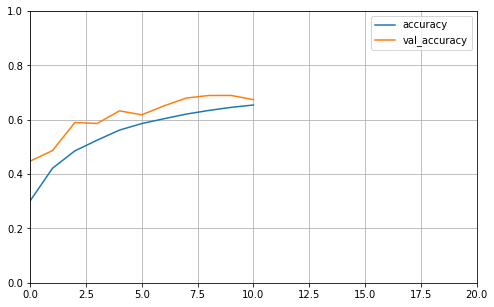

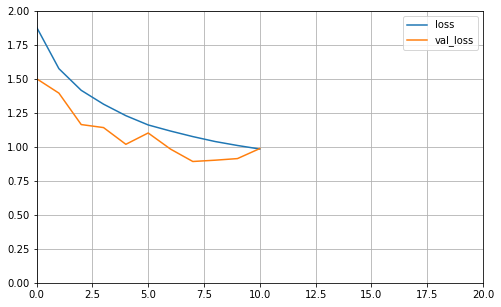

In [11]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

## 模型预测

In [12]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale= 1./255, # 缩放到0-1之间
)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = 'sparse'
)

test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [13]:
# 预测
test_predict = model.predict_generator(
    test_generator,
    workers = 4,
#     use_multiprocessing = True
)

In [14]:
print(test_predict.shape)

(300000, 10)


In [15]:
print(test_predict[0:5])

[[1.19752169e-01 1.97736397e-02 1.87746808e-01 1.21884443e-01
  2.00869158e-01 8.07953775e-02 4.16674986e-02 7.32287019e-02
  5.77242374e-02 9.65579823e-02]
 [5.95469415e-01 2.41348259e-02 2.68329252e-02 8.76767468e-03
  1.09298825e-02 1.09132123e-03 9.06108599e-03 1.71968562e-03
  1.68620404e-02 3.05131167e-01]
 [3.27107002e-04 3.34682465e-02 2.92815685e-07 6.75953004e-07
  4.28483204e-08 1.66831065e-08 2.87153199e-07 6.09965764e-06
  3.20274485e-05 9.66165245e-01]
 [2.52128318e-02 9.88447806e-04 1.86447520e-04 1.03312828e-04
  1.09217326e-04 5.01413160e-06 3.08552371e-05 1.21058511e-05
  9.70176160e-01 3.17557761e-03]
 [7.14224756e-01 8.79984582e-05 2.10715935e-01 9.21514910e-03
  2.38626227e-02 1.45898783e-03 6.03097142e-04 2.24490347e-03
  3.69998068e-02 5.86773618e-04]]


In [16]:
# 获取预测的索引
test_predict_class_indices = np.argmax(test_predict, axis = 1)

In [17]:
print(test_predict_class_indices[0:5])

[4 0 9 8 0]


In [18]:
# 获取预测的类别名称
test_predict_class = [class_names[index] for index in test_predict_class_indices]

In [19]:
print(test_predict_class[0:5])

['deer', 'airplane', 'truck', 'ship', 'airplane']


In [20]:
# 生成submission文件
def generate_submissions(filename, predict_class):
    with open(filename, 'w') as f:
        f.write('id,label\n')
        for i in range(len(predict_class)):
            f.write('%d,%s\n' % (i+1, predict_class[i]))
            
output_file = './data/cifar10/submission.csv'
generate_submissions(output_file, test_predict_class)

Describe Submission:

train 45000,20 epochs,basic model with only conv + bn + pooling